<a href="https://colab.research.google.com/github/linhlinhle997/AIO2024_Exercises/blob/feature%2Fexercices-module06/AIO2024_Exercises/module06%20/week01_CNN/ntc_scv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/congnghia0609/ntc-scv.git
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv

In [ ]:
!pip install langid

In [ ]:
!pip install torchtext==0.16.0

In [6]:
import os
import pandas as pd
import re
import string
import time
import matplotlib.pyplot as plt

from langid.langid import LanguageIdentifier, model
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn.functional as F

## Preprocessing data

In [7]:
def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
            sentence = "".join(lines)
            if label == "neg":
                label = 0
            if label == "pos":
                label = 1
            data = {
                "sentence": sentence,
                "label": label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [8]:
folder_paths = {
    "train": "./data/data_train/train",
    "valid": "./data/data_train/test",
    "test": "./data/data_test/test",
}

train_df = load_data_from_path(folder_paths["train"])
valid_df = load_data_from_path(folder_paths["valid"])
test_df = load_data_from_path(folder_paths["test"])

In [9]:
def identify_vn(df):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    not_vi_idx = set()
    THRESHOLD = 0.9
    for idx, row in df.iterrows():
        # Get the classification result and probability for the sentence
        score = identifier.classify(row["sentence"])

        # Check if the sentence is not Vietnamese or has low probability for Vietnamese
        if score[0] != "vi" or (score[0] == "vi" and score[1] <= THRESHOLD):
            not_vi_idx.add(idx) # Add index of non-Vietnamese sentences to the set

    # Create DataFrames: one for Vietnamese sentences and one for non-Vietnamese sentences
    vi_df = df[~df.index.isin(not_vi_idx)]
    not_vi_df = df[df.index.isin(not_vi_idx)]
    return vi_df, not_vi_df

In [10]:
train_df_vi, train_df_other = identify_vn(train_df)

In [11]:
def preprocess_text(text):
    # Remove URLs
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(" ", text)

    # Remove HTML tags
    html_pattern = re.compile(r"<[^<>]+>")
    text = html_pattern.sub(" ", text)

    # Remove punctuation and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    emoji_pattern = re.compile(
        r"["  # Start of the character class for emojis
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # Flags
        u"\U00002702-\U000027B0"  # Miscellaneous symbols
        u"\U000024C2-\U0001F251"  # Enclosed characters
        u"\U0001F926-\U0001F937"  # Emoticons (facepalm, etc.)
        u"\U0001F1F2"              # Some specific flag
        u"\U0001F1F4"              # More specific flags
        u"\U0001F620"              # More emoticons
        u"\u200d"                  # Zero width joiner (used in some emojis)
        u"\u2640-\u2642"           # Gender symbols
        "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(" ", text)

    # Normalize white spaces by splitting and joining the words
    text = " ".join(text.split())

    # Convert text to lowercase
    return text.lower()

In [12]:
train_df_vi["preprocess_sentence"] = [preprocess_text(row["sentence"]) for idx, row in train_df_vi.iterrows()]
valid_df["preprocess_sentence"] = [preprocess_text(row["sentence"]) for idx, row in valid_df.iterrows()]
test_df["preprocess_sentence"] = [preprocess_text(row["sentence"]) for idx, row in test_df.iterrows()]

<ipython-input-12-09f7a3c1bff9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi["preprocess_sentence"] = [preprocess_text(row["sentence"]) for idx, row in train_df_vi.iterrows()]


In [13]:
train_df_vi[:5]

,sentence,label,preprocess_sentence
0,Đi 2 lần r lần đầu kím đường muốn chết tới nơi...,0,đi lần r lần đầu kím đường muốn chết tới nơi t...
1,"Ở gần nhà nên cũng ghé qua ăn 2,3 lần . Quán c...",0,ở gần nhà nên cũng ghé qua ăn lần quán có nhiề...
2,"Ta ̀ u hu ̉ cư ̣ c dơ ̉ , nha ̣ t nhe ̃ o lă ́...",0,ta ̀ u hu ̉ cư ̣ c dơ ̉ nha ̣ t nhe ̃ o lă ́ m...
3,Đô ̀ ăn k qua ́ dơ ̉ nhưng cu ̃ ng chưa ngon :...,0,đô ̀ ăn k qua ́ dơ ̉ nhưng cu ̃ ng chưa ngon n...
4,Được bạn_bè giới_thiệu về phong_cách trang_trí...,0,được bạn bè giới thiệu về phong cách trang trí...


In [14]:
def yield_tokens(sentences, tokenizer):
    # Tokenizes sentences into individual words using the tokenizer.
    for sentence in sentences:
        yield tokenizer(sentence)

In [15]:
# Initializes a basic tokenizer for English text.
tokenizer = get_tokenizer("basic_english")

In [16]:
# Builds a vocabulary from tokenized sentences, limiting the vocabulary size to 10,000 words,
# and handles out-of-vocabulary words with <unk>.

vocab_size = 10000

# Build vocabulary from tokenized training sentences
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi["preprocess_sentence"], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)

# Set the default index for unknown words to the index of "<unk>"
vocabulary.set_default_index(vocabulary["<unk>"])

Ex:
- `Input sentences`: ["this is a test", "hello world", "this is another example"]
- `After tokenization`: [["this", "is", "a", "test"], ["hello", "world"], ["this", "is", "another", "example"]]
- `Vocabulary`: vocab_size=5 => vocabulary = {"`<pad>`": 0, "`<unk>`": 1, "this": 2, "is": 3, "a": 4, "test": 5}

In [17]:
# Prepares the dataset by converting each sentence into word indices from the vocabulary
# and assigns a label to the sentence.
def prepare_dataset(df):
    for index, row in df.iterrows():
        sentence = row["preprocess_sentence"]
        encoded_sentence = vocabulary(tokenizer(sentence)) # Tokenized and encoded sentence
        label = row["label"]
        yield encoded_sentence, label

```
[
    ([2, 3, 4, 5], 0),  # Sentence "this is a test", label 0
    ([6, 7], 1),        # Sentence "hello world", label 1
    ([2, 3, 8, 9], 1)   # Sentence "this is another example", label 2
]
```

In [18]:
train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

### DataLoader

In [19]:
def collate_batch(batch):
    # Create inputs, offsets, labels for batch
    encoded_sentences, labels = [], []
    for encoded_sentence, label in batch:
        labels.append(label)
        encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)
        encoded_sentences.append(encoded_sentence)

    labels = torch.tensor(labels, dtype=torch.int64)

    # Pad the sequences in encoded_sentences so that they all have the same length
    # padding_value is set to the index of the "<pad>" token in the vocabulary
    encoded_sentences = pad_sequence(
        encoded_sentences,
        padding_value=vocabulary["<pad>"]
    )
    return encoded_sentences, labels

tensor([[2, 3, 4, 2],
        [6, 7, 0, 0]])  # Padding với "`<pad>`" = 0
        

In [20]:
batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [21]:
next(iter(train_dataloader))

(tensor([[  2,  20, 636,  ..., 986, 342,   3],
         [ 11,   5, 573,  ...,  15, 356, 209],
         [ 47,  95, 129,  ...,   1, 241, 500],
         ...,
         [  0,   0,   0,  ..., 645,   0,   0],
         [  0,   0,   0,  ...,  15,   0,   0],
         [  0,   0,   0,  ...,  75,   0,   0]]),
 tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
         0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
         0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
         0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
         0, 1, 0, 0, 0, 1, 0, 0]))

- The first tensor is the batch of input sentences, represented as tokenized and padded sequences of integers.
- The second tensor is the batch of labels corresponding to the sentences, used for supervised learning tasks like classification.

In [22]:
encoded_sentences, labels = next(iter(train_dataloader))
encoded_sentences.shape

torch.Size([540, 128])

## Setup Model

In [23]:
def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_samples = 0, 0
    losses = []
    start_time = time.time()

    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(inputs)

        # Compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) # Clip gradient norm
        optimizer.step()

        # Update metrics
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_samples += labels.size(0)

        # Log progress at intervals
        if batch_idx % log_interval == 0 and batch_idx > 0:
            elapsed = time.time() - start_time
            print(
                f"| Epoch {epoch:3d} | Batch {batch_idx:5d}/{len(train_dataloader):5d} | "
                f"Accuracy {total_acc / total_samples:.3f}"
            )
            total_acc, total_samples = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_samples
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

def evaluate(model, criterion, device, valid_dataloader):
    model.eval()
    total_acc, total_samples = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            predictions = model(inputs)

            # Compute loss
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            # Update metrics
            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_samples += labels.size(0)

    epoch_acc = total_acc / total_samples
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

### TextCNN

In [24]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, kernel_sizes, num_filters, num_classes):
        super(TextCNN, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.num_classes = num_classes

        # Embedding layer: Converts word indices into continuous vectors (embeddings)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Create a list of convolutional layers (one for each kernel size)
        # Each convolutional layer takes the embedded word vectors as input and applies filters of size 'k'
        self.conv = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=k, # Kernel size: different values for each convolution layer
                stride=1
            ) for k in kernel_sizes # Loop through all kernel sizes
        ])

        # Fully connected layer: Converts extracted features from convolutional layers into class predictions
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        # Convert word indices into word embeddings
        x = self.embedding(x.T).transpose(1, 2)

        # Apply convolutional layers with ReLU activation
        x = [F.relu(conv(x)) for conv in self.conv]

        # Apply max pooling to each convolutional output, selecting the most important feature
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]

        # Concatenate all pooled features together
        x = torch.cat(x, dim=1)

        # Pass the concatenated features through the fully connected layer to make class predictions
        x = self.fc(x)
        return x

In [25]:
# Setup
num_class = 2
vocab_size = len(vocabulary)
embedding_dim = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, criterion, optimizer
model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 2e-4)

model

TextCNN(
  (embedding): Embedding(10000, 300, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

In [26]:
# Training parameters
num_epochs = 10
model_dir = "./models"
os.makedirs(model_dir, exist_ok=True)

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_eval_loss = float("inf")

for epoch in range(1, num_epochs + 1):
    start_time  = time.time()

    # Train
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(model, criterion, device, valid_dataloader)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save the model if it has the best evaluation loss
    if eval_loss < best_eval_loss:
        torch.save(model.state_dict(), os.path.join(model_dir, "text_cnn_model.pth"))

    # Logging
    elapsed_time = time.time() - start_time
    print("=" * 59)
    print(
        f"End of Epoch {epoch:3d} | Time: {elapsed_time:.2f}s | "
        f"Train Acc: {train_acc:.3f}, Train Loss: {train_loss:.3f} | "
        f"Val Acc: {eval_acc:.3f}, Val Loss: {eval_loss:.3f}"
    )
    print("=" * 59)

    # Load the best model
    model.load_state_dict(torch.load(os.path.join(model_dir, "text_cnn_model.pth")))
    model.eval()

| Epoch   1 | Batch    50/  233 | Accuracy 0.746
| Epoch   1 | Batch   100/  233 | Accuracy 0.833
| Epoch   1 | Batch   150/  233 | Accuracy 0.851
| Epoch   1 | Batch   200/  233 | Accuracy 0.868
End of Epoch   1 | Time: 19.10s | Train Acc: 0.869, Train Loss: 0.404 | Val Acc: 0.870, Val Loss: 0.322
| Epoch   2 | Batch    50/  233 | Accuracy 0.906
| Epoch   2 | Batch   100/  233 | Accuracy 0.913
| Epoch   2 | Batch   150/  233 | Accuracy 0.904
| Epoch   2 | Batch   200/  233 | Accuracy 0.911
End of Epoch   2 | Time: 17.20s | Train Acc: 0.906, Train Loss: 0.252 | Val Acc: 0.883, Val Loss: 0.291
| Epoch   3 | Batch    50/  233 | Accuracy 0.944
| Epoch   3 | Batch   100/  233 | Accuracy 0.945
| Epoch   3 | Batch   150/  233 | Accuracy 0.937
| Epoch   3 | Batch   200/  233 | Accuracy 0.939
End of Epoch   3 | Time: 17.22s | Train Acc: 0.941, Train Loss: 0.182 | Val Acc: 0.885, Val Loss: 0.282
| Epoch   4 | Batch    50/  233 | Accuracy 0.972
| Epoch   4 | Batch   100/  233 | Accuracy 0.967
| 

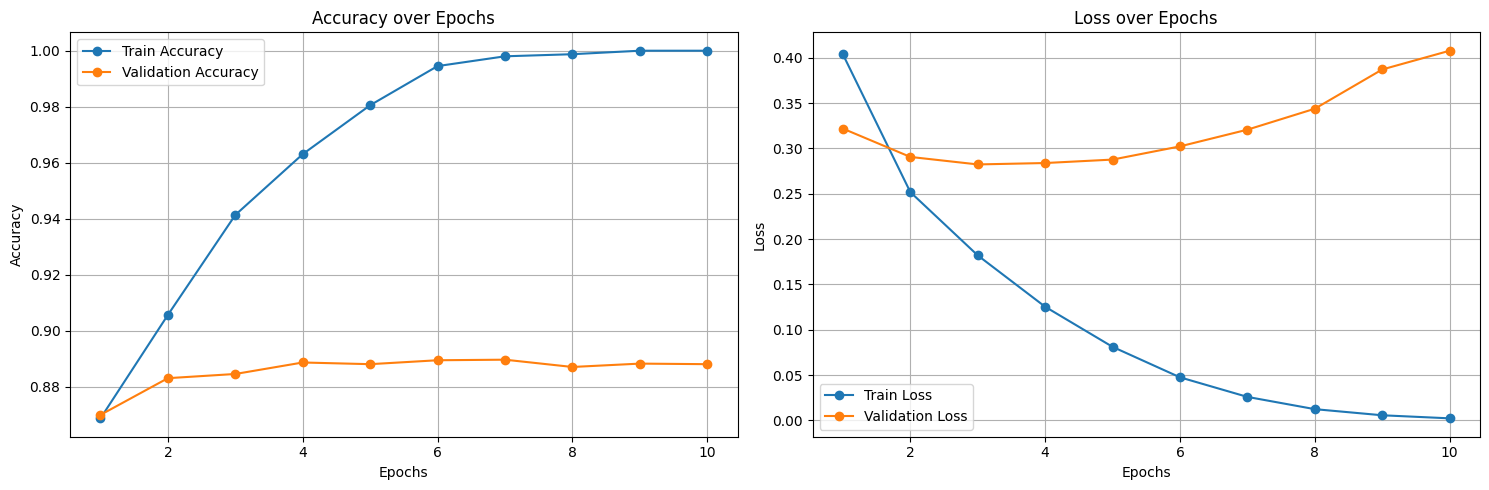

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(range(1, num_epochs + 1), train_accs, label="Train Accuracy", marker='o')
axes[0].plot(range(1, num_epochs + 1), eval_accs, label="Validation Accuracy", marker='o')
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid()

axes[1].plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
axes[1].plot(range(1, num_epochs + 1), eval_losses, label="Validation Loss", marker='o')
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


### Evalation

In [28]:
test_acc, test_loss = evaluate(model, criterion, device, test_dataloader)
test_acc, test_loss

(0.8983, 0.3715136449171018)

### Inference

In [32]:
tokenizr = get_tokenizer("basic_english")

def load_model(model_path, vocab_size=10000, embedding_dim=300, num_classes=2):
    model = TextCNN(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        kernel_sizes=[3, 4, 5],
        num_filters=100,
        num_classes=2
    ).to(device)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    return model


def inference(sentence, vocabulary, model):
    # Preprocess the input sentence (e.g., lowercasing, removing punctuation)
    sentence = preprocess_text(sentence)

    # Tokenize the sentence and convert tokens to indices using the vocabulary
    encoded_sentence = vocabulary(tokenizer(sentence))

    # Convert the list of indices to a tensor
    encoded_sentence = torch.tensor(encoded_sentence).to(device)

    # Add an extra dimension (batch dimension) to the tensor
    encoded_sentence = torch.unsqueeze(encoded_sentence, 1)

    with torch.no_grad():
        # Get model predictions for the encoded sentence
        predictions = model(encoded_sentence)

    # Apply the Softmax function to convert logits to probabilities
    preds = nn.Softmax(dim=1)(predictions)

     # Get the predicted class with the highest probability
    p_max, y_hat = torch.max(preds.data, 1)
    return round(p_max.item(), 2)*100, y_hat.item()

In [40]:
test_sentence = test_df['preprocess_sentence'][5999]
test_df.iloc[5999]

,5999
sentence,"Nếp_cẩm ngon lắm nhé , ngon hơn mấy chỗ trên S..."
label,1
preprocess_sentence,nếp cẩm ngon lắm nhé ngon hơn mấy chỗ trên sg ...


In [34]:
model = load_model("./models/text_cnn_model.pth")
preds = inference(test_sentence, vocabulary, model)
preds

(100.0, 1)

In [35]:
test_df

,sentence,label,preprocess_sentence
0,Thực_ra hôm đấy mình có_học buổi chiều nên lúc...,0,thực ra hôm đấy mình có học buổi chiều nên lúc...
1,"Đi dự hội_thảo được voucher free 200k , tại vì...",0,đi dự hội thảo được voucher free k tại vì có đ...
2,Cũng trả tiền chứ có xin không_đâu mà khách tớ...,0,cũng trả tiền chứ có xin không đâu mà khách tớ...
3,Quán làm_ăn rất là kém mà nói_thẳng là tệ . Nh...,0,quán làm ăn rất là kém mà nói thẳng là tệ nhân...
4,Quán mới có ưu_đãi cho mọi người đi từ 4 người...,0,quán mới có ưu đãi cho mọi người đi từ người t...
...,...,...,...
9995,Chắc_chắn mình sẽ gới thiệu cho bạn_bè . Đúng ...,1,chắc chắn mình sẽ gới thiệu cho bạn bè đúng vớ...
9996,Quán này ăn OK lắm nha ✌ 🏻 ️ bây giừ Lagi mở_m...,1,quán này ăn ok lắm nha bây giừ lagi mở mặt tiề...
9997,Set lẩu 200k 2ng nhìn lúc đầu khá đầy_đặn : ) ...,1,set lẩu k ng nhìn lúc đầu khá đầy đặn về sau t...
9998,"Thích nhất không_gian ở BKS , màu_sắc và không...",1,thích nhất không gian ở bks màu sắc và không k...


In [42]:
inference(test_df['preprocess_sentence'][0], vocabulary, model)

(67.0, 1)

In [43]:
inference(test_df['preprocess_sentence'][2], vocabulary, model)

(100.0, 0)

In [44]:
inference(test_df['preprocess_sentence'][9995], vocabulary, model)

(100.0, 1)

In [36]:
inference('Đồ ăn rất ngon và rẻ', vocabulary, model)

(74.0, 0)